# Generating Predictive Models Tracked via MLflow

## Preprocessing
### Libraries

In [56]:
# Standard libraries
import warnings
import os

# Third-party libraries: General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import lightgbm as lgb
import shap
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
import pickle
import shutil

# Third-party libraries: scikit-learn and imblearn
from sklearn.impute import KNNImputer
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
)
from sklearn.metrics import (
    make_scorer,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    fbeta_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Local application/library specific imports
from business_cost_metric import business_cost_metric


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

### Preprocessing Functions (Including Feature Engineering)
These functions were adapted from the Kaggle kernel "LightGBM with Simple Features" at https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [57]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv("input/application_train.csv", nrows=num_rows)
    test_df = pd.read_csv("input/application_test.csv", nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df]).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df["CODE_GENDER"] != "XNA"]

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]
    del test_df
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv("input/bureau.csv", nrows=num_rows)
    bb = pd.read_csv("input/bureau_balance.csv", nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {"MONTHS_BALANCE": ["min", "max", "size"]}
    for col in bb_cat:
        bb_aggregations[col] = ["mean"]
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]
    )
    bureau = bureau.join(bb_agg, how="left", on="SK_ID_BUREAU")
    bureau.drop(["SK_ID_BUREAU"], axis=1, inplace=True)
    del bb, bb_agg

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        "DAYS_CREDIT": ["min", "max", "mean", "var"],
        "DAYS_CREDIT_ENDDATE": ["min", "max", "mean"],
        "DAYS_CREDIT_UPDATE": ["mean"],
        "CREDIT_DAY_OVERDUE": ["max", "mean"],
        "AMT_CREDIT_MAX_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM_LIMIT": ["mean", "sum"],
        "AMT_ANNUITY": ["max", "mean"],
        "CNT_CREDIT_PROLONG": ["sum"],
        "MONTHS_BALANCE_MIN": ["min"],
        "MONTHS_BALANCE_MAX": ["max"],
        "MONTHS_BALANCE_SIZE": ["mean", "sum"],
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ["mean"]
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ["mean"]

    bureau_agg = bureau.groupby("SK_ID_CURR").agg(
        {**num_aggregations, **cat_aggregations}
    )
    bureau_agg.columns = pd.Index(
        ["BURO_" + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()]
    )
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
    active_agg.columns = pd.Index(
        ["ACTIVE_" + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")
    del active, active_agg
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
    closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ["CLOSED_" + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")
    del closed, closed_agg, bureau
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv("input/previous_application.csv", nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev["DAYS_FIRST_DRAWING"].replace(365243, np.nan, inplace=True)
    prev["DAYS_FIRST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE_1ST_VERSION"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_TERMINATION"].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev["APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / prev["AMT_CREDIT"]
    # Previous applications numeric features
    num_aggregations = {
        "AMT_ANNUITY": ["min", "max", "mean"],
        "AMT_APPLICATION": ["min", "max", "mean"],
        "AMT_CREDIT": ["min", "max", "mean"],
        "APP_CREDIT_PERC": ["min", "max", "mean", "var"],
        "AMT_DOWN_PAYMENT": ["min", "max", "mean"],
        "AMT_GOODS_PRICE": ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START": ["min", "max", "mean"],
        "RATE_DOWN_PAYMENT": ["min", "max", "mean"],
        "DAYS_DECISION": ["min", "max", "mean"],
        "CNT_PAYMENT": ["mean", "sum"],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ["mean"]

    prev_agg = prev.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(
        ["PREV_" + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()]
    )
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev["NAME_CONTRACT_STATUS_Approved"] == 1]
    approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ["APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()]
    )
    prev_agg = prev_agg.join(approved_agg, how="left", on="SK_ID_CURR")
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev["NAME_CONTRACT_STATUS_Refused"] == 1]
    refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ["REFUSED_" + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()]
    )
    prev_agg = prev_agg.join(refused_agg, how="left", on="SK_ID_CURR")
    del refused, refused_agg, approved, approved_agg, prev
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv("input/POS_CASH_balance.csv", nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        "MONTHS_BALANCE": ["max", "mean", "size"],
        "SK_DPD": ["max", "mean"],
        "SK_DPD_DEF": ["max", "mean"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    pos_agg = pos.groupby("SK_ID_CURR").agg(aggregations)
    pos_agg.columns = pd.Index(
        ["POS_" + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()]
    )
    # Count pos cash accounts
    pos_agg["POS_COUNT"] = pos.groupby("SK_ID_CURR").size()
    del pos
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv("input/installments_payments.csv", nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins["PAYMENT_PERC"] = ins["AMT_PAYMENT"] / ins["AMT_INSTALMENT"]
    ins["PAYMENT_DIFF"] = ins["AMT_INSTALMENT"] - ins["AMT_PAYMENT"]
    # Days past due and days before due (no negative values)
    ins["DPD"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["DBD"] = ins["DAYS_INSTALMENT"] - ins["DAYS_ENTRY_PAYMENT"]
    ins["DPD"] = ins["DPD"].apply(lambda x: x if x > 0 else 0)
    ins["DBD"] = ins["DBD"].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "DPD": ["max", "mean", "sum"],
        "DBD": ["max", "mean", "sum"],
        "PAYMENT_PERC": ["max", "mean", "sum", "var"],
        "PAYMENT_DIFF": ["max", "mean", "sum", "var"],
        "AMT_INSTALMENT": ["max", "mean", "sum"],
        "AMT_PAYMENT": ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]
    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index(
        ["INSTAL_" + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()]
    )
    # Count installments accounts
    ins_agg["INSTAL_COUNT"] = ins.groupby("SK_ID_CURR").size()
    del ins
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv("input/credit_card_balance.csv", nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(["SK_ID_PREV"], axis=1, inplace=True)
    cc_agg = cc.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
    cc_agg.columns = pd.Index(
        ["CC_" + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()]
    )
    # Count credit card lines
    cc_agg["CC_COUNT"] = cc.groupby("SK_ID_CURR").size()
    del cc
    return cc_agg

### Joining Tables and Saving Results

In [58]:
# Check whether the pretreated dataframes already exist; if they do, just read them into memory.
if not os.path.exists("input/train_df.ftr") or not os.path.exists("input/test_df.ftr"):
    # Pretreatment and feature engineering of combined application dfs
    df = application_train_test()
    # Pretreat and join bureau and balance tables to applications
    bureau = bureau_and_balance()
    df = df.join(bureau, how="left", on="SK_ID_CURR")

    # Save memory
    del bureau

    # Pretreat and join previous applications
    prev = previous_applications()
    df = df.join(prev, how="left", on="SK_ID_CURR")

    del prev

    # Pretreat and join pos
    pos = pos_cash()
    df = df.join(pos, how="left", on="SK_ID_CURR")

    del pos

    # Pretreat and join installments
    ins = installments_payments()
    df = df.join(ins, how="left", on="SK_ID_CURR")

    del ins

    # Pretreat and join credit card balance
    cc = credit_card_balance()
    df = df.join(cc, how="left", on="SK_ID_CURR")

    del cc

    # Seperate train and test dfs based on presence of TARGET
    train_df = df[df["TARGET"].notnull()].reset_index(drop=True)
    test_df = df[df["TARGET"].isnull()].reset_index(drop=True)

    del df

    # Save dfs to feather files
    train_df.to_feather("input/train_df.ftr")
    test_df.to_feather("input/test_df.ftr")

else:
    # Read pretreated dfs into memory if they already exist
    train_df = pd.read_feather("input/train_df.ftr")
    test_df = pd.read_feather("input/test_df.ftr")

# Show size of train and test dfs
print(f"train_df has {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
print(f"test_df has {test_df.shape[0]} rows and {test_df.shape[1]} columns.")

train_df has 307507 rows and 797 columns.
test_df has 48744 rows and 797 columns.


### Selecting the Top 50 Columns Most Correlated with 'TARGET'

**Purpose:**
- **Dimensionality Reduction**: The initial dataset had 797 columns. By selecting the 50 columns with the highest correlation to the 'TARGET', we've significantly reduced the dimensionality to 52 columns (including 'SK_ID_CURR' and 'TARGET'). This choice is partly influenced by computational constraints, ensuring that subsequent processing is efficient.

- **Arbitrary Selection**: The choice of exactly 50 columns, while influenced by computational considerations, is somewhat arbitrary. However, the aim was to strike a balance between computational efficiency and retaining meaningful data for subsequent steps.

- **Imputation**: By narrowing our focus to columns with significant correlations to the 'TARGET', we simplify and potentially improve the quality of subsequent imputation processes. Fewer columns might allow for more accurate imputation based on the existing relationships.
  
- **Oversampling**: When dealing with imbalanced datasets, the process of oversampling can introduce noise. By concentrating on the most relevant features, we aim to retain the most meaningful information and minimize the noise during oversampling.

In [59]:
# Calculate correlations for column 'TARGET' against all other columns
correlations = (
    train_df.drop(columns=["SK_ID_CURR"])
    .corr()["TARGET"]
    .drop("TARGET", errors="ignore")
)

# Sort correlations by absolute values but retain the original negative/positive values; reserve 50 columns with
# the most significant correlations
top_sorted_correlations = correlations.reindex(
    correlations.abs().nlargest(50).sort_values(ascending=False).index
)

# Display the resulting 50 columns with their correlation coefficients
with pd.option_context("display.max_rows", None):
    print(top_sorted_correlations)

# Filter the dataframe
train_df = train_df[["SK_ID_CURR", "TARGET"] + top_sorted_correlations.index.tolist()]

# Show size of train_df
print(f"\ntrain_df has {train_df.shape[0]} rows and {train_df.shape[1]} columns.")

EXT_SOURCE_3                              -0.178926
EXT_SOURCE_2                              -0.160471
EXT_SOURCE_1                              -0.155317
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN           0.107692
CC_CNT_DRAWINGS_CURRENT_MAX                0.101389
BURO_DAYS_CREDIT_MEAN                      0.089731
CC_AMT_BALANCE_MEAN                        0.087177
CC_AMT_TOTAL_RECEIVABLE_MEAN               0.086490
CC_AMT_RECIVABLE_MEAN                      0.086478
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN           0.086062
CC_CNT_DRAWINGS_CURRENT_MEAN               0.082520
BURO_MONTHS_BALANCE_SIZE_MEAN             -0.080193
BURO_CREDIT_ACTIVE_Closed_MEAN            -0.079369
DAYS_BIRTH                                 0.078242
PREV_NAME_CONTRACT_STATUS_Refused_MEAN     0.077681
BURO_CREDIT_ACTIVE_Active_MEAN             0.077356
BURO_DAYS_CREDIT_MIN                       0.075248
DAYS_EMPLOYED                              0.074957
PREV_CODE_REJECT_REASON_XAP_MEAN          -0.073938
CC_AMT_INST_

### Stratified Sampling of Train Data

To optimize computational efficiency during model development and evaluation, a subset of the dataset is extracted. It's pivotal that this sample accurately reflects the `TARGET` class distribution present in the larger dataset. To achieve this, the following strategy is employed:

- **StratifiedShuffleSplit**: Utilizing the `StratifiedShuffleSplit` method ensures that the sampled dataset mirrors the class distribution of the original. This technique offers a reliable way to maintain class imbalances.

- **Sample Size**: The sample consists of 10,000 instances, chosen to balance computational speed with a sufficiently large dataset for reliable modeling.

The outputs present the `TARGET` class distribution ratios, verifying the sampled set is representative of the original data.

In [60]:
# Create an instance of StratifiedShuffleSplit for stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=10000)

# Get the indices for the sampled data
_, sampled_index = next(sss.split(train_df, train_df["TARGET"]))
# Extract the sample rows based on the indices
sampled_train_df = train_df.iloc[sampled_index]

# Calculate the ratio in the original and sampled dataframe
original_ratio = train_df["TARGET"].value_counts(normalize=True)
sampled_ratio = sampled_train_df["TARGET"].value_counts(normalize=True)

# Display the ratios
print(f"Original dataframe TARGET ratio: {original_ratio}")
print(f"Sampled dataframe TARGET ratio: {sampled_ratio}")

Original dataframe TARGET ratio: TARGET
0.0    0.91927
1.0    0.08073
Name: proportion, dtype: float64
Sampled dataframe TARGET ratio: TARGET
0.0    0.9193
1.0    0.0807
Name: proportion, dtype: float64


### KNN Imputation for Missing Data

- Missing data is being addressed to ensure subsequently trained models, which cannot handle missing data, function properly.
- **KNN Imputation** has been chosen for this task:
  * It imputes missing values using the mean value from `k` nearest neighbors.
  * `k=5` has been used as a commonly recommended starting point, balancing computational cost and the ability to capture data patterns.
  * KNN captures patterns that simpler methods might miss.
- Given the reduced sample size, computational expense isn't a concern.

In [61]:
# Using KNN Imputer with 5 neighbors to impute missing values in the sampled_train_df,
# and then converting the resulting numpy array back into a DataFrame with the original column names.
sampled_train_df_imputed = pd.DataFrame(
    KNNImputer(n_neighbors=5).fit_transform(sampled_train_df),
    columns=sampled_train_df.columns,
)

### Splitting the Sampled Data

In this section, the goal is to prepare the dataset for subsequent model training and evaluation. To ensure the evaluation is unbiased, the data is split into training and testing sets. Both the original sampled data and the KNN-imputed data undergo this split.

**Considerations**:
- **Consistency**: It's essential to maintain consistency in the split for the original and imputed datasets. This ensures that a particular observation ends up in the training set (or test set) for both datasets.
- **ID Preservation**: While IDs (`SK_ID_CURR`) aren't used directly in the modeling process, they're retained separately. This helps trace back the predictions or any transformations to the original records if needed.

In [62]:
# Splitting the dataset into training and testing sets.
# Ensuring consistency in the split across the original and imputed datasets.
# Additionally, preserving the SK_ID_CURR for potential future referencing.
(
    X_train,
    X_test,
    y_train,
    y_test,
    X_imputed_train,
    X_imputed_test,
    y_imputed_train,
    y_imputed_test,
    SK_ID_CURR_train,
    SK_ID_CURR_test,
) = train_test_split(
    sampled_train_df.drop(
        columns=["SK_ID_CURR", "TARGET"]
    ),  # Dropping ID and target from the original data
    sampled_train_df["TARGET"],  # Extracting the target from the original data
    sampled_train_df_imputed.drop(
        columns=["SK_ID_CURR", "TARGET"]
    ),  # Replicating the split for the imputed data
    sampled_train_df_imputed["TARGET"],
    sampled_train_df["SK_ID_CURR"],  # Preserving the ID column
    test_size=0.2,  # Designating 20% of the data for testing
)

### Further Refining Feature Set Using SelectKBest

In this step, we further refine the feature set by selecting the top 20 columns that are most predictive of the target variable, "TARGET". This is accomplished using the `SelectKBest` method, paired with the `mutual_info_classif` score function, which captures non-linear relationships:

- **Initialize Selector**: A `SelectKBest` selector is set up using `mutual_info_classif` to determine the significance of each feature with respect to the target.
- **Fit and Transform**: The selector is then fitted to the imputed training data, subsequently transforming the data by retaining only the top 20 features.
- **Identify Top Features**: Once the transformation is complete, the column names of these selected features are extracted and stored.
- **Filter Data**: With the top features identified, the original and imputed training and test datasets are filtered to include only these columns.

By the end of this process, the datasets are primed with a concise set of features, poised for effective modeling.

In [63]:
# Check if the final selction of independent features has already been generated
# The data samples will have changed, so KBest can select different columns on subsequent runs, which breaks existing estimators
if not os.path.exists("final_ind_feats.pkl"):
    # Initialize the SelectKBest selector using mutual_info_classif as the score function and k=20 to select top 20 features.
    selector = SelectKBest(mutual_info_classif, k=20)

    # Fit the selector to the training data and transform the data, keeping only the top 20 features.
    selector.fit_transform(X_imputed_train, y_imputed_train)

    # Extract the column names of the top 20 features selected by the selector.
    final_ind_feats = X_imputed_train.columns[selector.get_support()].tolist()

    # Save the list of column names to a pickle file
    with open("final_ind_feats.pkl", "wb") as f:
        pickle.dump(final_ind_feats, f)
else:
    # If it exists, read the list of column names into a variable
    with open("final_ind_feats.pkl", "rb") as f:
        final_ind_feats = pickle.load(f)

# Print out the names of the selected columns.
print(f"Selected columns are: {final_ind_feats}")

# Filter the original training and test datasets to include only the selected columns.
X_train = X_train[final_ind_feats]
X_test = X_test[final_ind_feats]

# Filter the imputed training and test datasets to include only the selected columns.
X_imputed_train = X_imputed_train[final_ind_feats]
X_imputed_test = X_imputed_test[final_ind_feats]

Selected columns are: ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'BURO_DAYS_CREDIT_MEAN', 'BURO_CREDIT_ACTIVE_Closed_MEAN', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'BURO_DAYS_CREDIT_MIN', 'DAYS_EMPLOYED', 'PREV_CODE_REJECT_REASON_XAP_MEAN', 'BURO_MONTHS_BALANCE_MIN_MIN', 'DAYS_EMPLOYED_PERC', 'CC_AMT_BALANCE_MIN', 'ACTIVE_DAYS_CREDIT_MEAN', 'CC_MONTHS_BALANCE_MEAN', 'CLOSED_DAYS_CREDIT_MIN', 'BURO_STATUS_1_MEAN_MEAN', 'REGION_RATING_CLIENT_W_CITY', 'ACTIVE_DAYS_CREDIT_MAX', 'CC_AMT_DRAWINGS_ATM_CURRENT_MEAN']


### Creating Scorers

Scorers are defined for various metrics to evaluate the model's performance:

- **ROC-AUC**: Measures the classifier's discriminative ability.
    - Maximizes TP and TN equally, thus reducing FP and FN equally.
- **Fβ**: With a β value of 10, it emphasizes the importance of recall (true positive rate) over precision.
    - Preferentially maximizes TP, thus reducing FN.
- **Business Cost**: A custom metric designed to heavily penalize false negatives.
    - Directly penalizes FN rate.

Finally, a nested array of metric names and scorers is created for use in training iterations.

In [64]:
# Scorer for ROC-AUC
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Scorer for Fβ
fbeta10_scorer = make_scorer(fbeta_score, beta=10)

# Scorer for the business cost metric
business_cost_scorer = make_scorer(business_cost_metric, needs_proba=True)

# A nested array of metric names and scorers for training iterations, ex. ["Metric", scorer]
scorers = [
    ["ROC-AUC", roc_auc_scorer],
    ["Fβ", fbeta10_scorer],
    ["business cost", business_cost_scorer],
]

### Function to Calculate Feature Importance Using SHAP

The `compute_shap_importance` function computes SHAP values, offering an intuitive approach to understanding the impact of features on model predictions:

- **Inputs**:
  - `model`: The trained machine learning model.
  - `X`: The dataset (or subset) used for calculating feature importances.
  - `row`: Optional. A single instance (dataframe row) for local interpretation.
  - `max_sample_size`: The maximum number of samples to consider from `X` to conserve computation.

- **Functionality**:
  1. If the size of `X` exceeds `max_sample_size`, it samples down to the specified size.
  2. For a binary classification model, it averages SHAP values over the positive class.
  3. Returns a dictionary of features ranked by their scaled SHAP values.

- **Outputs**:
  - `sorted_feats`: Features ranked based on their scaled SHAP values.

**Note**: The SHAP values are scaled by the maximum absolute SHAP value, referred to as max-abs scaling, which ensures that all scaled values fall within the range of [-1, 1]. This makes it easy to compare the relative importance of features while maintaining the original sign and relative magnitude of each value.


In [65]:
def compute_shap_importance(model, X, row=None, max_sample_size=100):
    # Subsample X if it's larger than the max_sample_size
    if len(X) > max_sample_size:
        X = X.sample(n=max_sample_size)

    # Define a custom prediction function that will use the pipeline's predict_proba method
    def pipeline_predict(data):
        return model.predict_proba(data)[:, 1]

    # Initialize the SHAP explainer using the custom prediction function
    explainer = shap.Explainer(pipeline_predict, X)

    # If a row (instance) is provided, compute local SHAP values
    # Otherwise, compute global SHAP values averaged over all instances in X
    if row is not None:
        shap_values = explainer.shap_values(row)
        feature_names = row.columns
    else:
        shap_values = explainer.shap_values(X)
        if (
            isinstance(shap_values, list) and len(shap_values) > 1
        ):  # For binary classification
            shap_values = np.mean(shap_values[1], axis=0)  # Use positive class
        else:  # Regression or single output
            shap_values = np.mean(shap_values, axis=0)
        feature_names = X.columns

    # Scale the SHAP values by the maximum absolute value
    scaled_shap_values = shap_values / np.max(np.abs(shap_values))

    # Create a dictionary of feature names and their corresponding scaled SHAP values
    feats_and_vals = {
        feature_names[i]: scaled_shap_values[i] for i in range(len(feature_names))
    }

    # Sort the features by their scaled SHAP values in descending order
    sorted_feats = dict(
        sorted(feats_and_vals.items(), key=lambda item: item[1], reverse=True)
    )

    return sorted_feats

### Model Training and Evaluation with MLflow

In this section, two functions are defined:

1. **`best_fit_pipeline`**: This function builds a pipeline for preprocessing and model training. Features are standardized by removing the mean and scaling to unit variance. Class imbalance is addressed by oversampling the minority class using SMOTE if specified in the arguments, otherwise class weights are given in the hyperparameters. A cross-validated randomized search is then used to optimize the hyperparameter settings for the given estimator based on the provided scorer.

2. **`train_model`**: This function trains the model using the aforementioned pipeline and logs important metrics, parameters, and the model itself to MLflow. It also plots the ROC curve and confusion matrix, calculates global feature importance, and logs them as artifacts.

In [66]:
def best_fit_pipeline(estim, params, scorer, n_iter, X_train, y_train, smote):
    # Build a pipeline with standard scaling, SMOTE sampling, and the desired estimator
    if smote:
        model = Pipeline(
            [
                ("standard scaling", StandardScaler()),
                ("sampling", SMOTE()),
                ("classification", estim),
            ]
        )
    else:
        model = Pipeline(
            [
                ("standard scaling", StandardScaler()),
                ("classification", estim),
            ]
        )

    # Use randomized search to find the best hyperparameters
    best_fit = RandomizedSearchCV(model, params, n_iter=n_iter, cv=5, scoring=scorer)
    best_fit.fit(X_train, y_train)

    return best_fit


def train_model(
    *,
    X_train,
    y_train,
    X_test,
    y_test,
    estimator,
    params,
    cv_metric,
    scorer,
    n_iter,
    run_name,
    model_type,
    smote,
    imputed,
):
    # Start an MLflow run
    with mlflow.start_run(run_name=run_name):
        # Choose graph colors
        colors = "mako"

        # Obtain the best model pipeline
        best_fit = best_fit_pipeline(
            estimator, params, scorer, n_iter, X_train, y_train, smote
        )

        # Log the model type to MLflow
        mlflow.log_param("model_type", model_type)

        # Log best hyperparameters to MLflow
        for param in best_fit.best_params_:
            mlflow.log_param(param.split("__")[1], best_fit.best_params_[param])

        # Make train and test set predictions
        train_y_pred = best_fit.predict(X_train)
        test_y_pred = best_fit.predict(X_test)

        # Get train and test set probability estimates
        train_y_proba = best_fit.predict_proba(X_train)[:, 1]
        test_y_proba = best_fit.predict_proba(X_test)[:, 1]

        # Calculate confusion matrix for test set predictions
        cf_matrix = confusion_matrix(y_test, best_fit.predict(X_test))

        # Log FP and FN of test set predictions
        tn, fp, fn, tp = cf_matrix.ravel()
        mlflow.log_metric("fp_pct_test", round(fp / len(X_test) * 100, 2))
        mlflow.log_metric("fn_pct_test", round(fn / len(X_test) * 100, 2))

        # Log whether oversampling was used in the pipeline
        mlflow.log_param("smote", smote)

        # Log whether imputed data was used
        mlflow.log_param("imputed", imputed)

        # Log hyperparameter tuning CV metric type
        mlflow.log_param("cv_metric", cv_metric)

        # Log mean cross-validated score of the best_estimator
        mlflow.log_metric("cv_score", best_fit.best_score_)

        # Log accuracy
        mlflow.log_metric("accu_train", accuracy_score(y_train, train_y_pred))
        mlflow.log_metric("accu_test", accuracy_score(y_test, test_y_pred))

        # Log business cost
        mlflow.log_metric("bus_cost_train", business_cost_metric(y_train, train_y_pred))
        mlflow.log_metric("bus_cost_test", business_cost_metric(y_test, test_y_pred))

        # Log Fβ score with β of 10
        beta_value = 10
        mlflow.log_metric(
            "fbeta_train", fbeta_score(y_train, train_y_pred, beta=beta_value)
        )
        mlflow.log_metric(
            "fbeta_test", fbeta_score(y_test, test_y_pred, beta=beta_value)
        )

        # Log ROC_AUC
        mlflow.log_metric("auc_train", roc_auc_score(y_train, train_y_proba))
        mlflow.log_metric("auc_test", roc_auc_score(y_test, test_y_proba))

        # Calculate  and log global feature importance
        glob_feat_import = compute_shap_importance(best_fit.best_estimator_, X_train)

        mlflow.log_dict(glob_feat_import, "glob_feat_import.json")

        # Save X_train to a pickle file
        temp_pickle_path = "X_train.pkl"
        X_train.to_pickle(temp_pickle_path)

        # Log the pickle file as an artifact
        mlflow.log_artifact(temp_pickle_path)

        # Delete the temporary pickle file
        os.remove(temp_pickle_path)

        # Log the trained model
        mlflow.sklearn.log_model(best_fit.best_estimator_, model_type)

        # Set the global palette and style
        sns.set_palette(colors)
        sns.set_style("darkgrid")

        # Create a figure and a 1x2 subplot (two axes side by side)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Plotting the ROC curve on ax1
        fpr, tpr, _ = roc_curve(y_test, test_y_proba)
        sns.lineplot(x=fpr, y=tpr, label="Model ROC", ax=ax1)
        current_palette = sns.color_palette()

        # Adding the line of no discrimination on ax1
        ax1.plot(
            [0, 1],
            [0, 1],
            linestyle="--",
            color=current_palette[1],
            label="Line of No Discrimination",
        )
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title("ROC Curve")
        ax1.legend(loc="lower right")

        # Plot confusion matrix
        group_names = ["TN", "FP", "FN", "TP"]
        group_percentages = [
            "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
        ]
        labels = [f"{v1}\n{v3}" for v1, v3 in zip(group_names, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)
        total_instances = np.sum(cf_matrix)

        # Create the heatmap on ax2
        sns.heatmap(
            cf_matrix,
            annot=labels,
            fmt="",
            vmin=0,
            vmax=total_instances,
            cmap=colors,
            ax=ax2,
        )

        # Get the colorbar
        cbar = ax2.collections[0].colorbar

        # Set new ticks for the colorbar
        new_ticks = [
            i * total_instances / 10 for i in range(11)
        ]  # Dividing into 10 equal parts
        cbar.set_ticks(new_ticks)

        # Format the ticks to be in percentages
        new_labels = ["{:.0%}".format(i / 10) for i in range(11)]
        cbar.set_ticklabels(new_labels)

        ax2.set_title("Confusion Matrix")

        # Display the plots
        plt.tight_layout()
        plt.show()

        # Save the combined plot to a specific path
        temp_filepath = "performance_graphs.png"
        fig.savefig(temp_filepath)

        # Upload to MLflow
        mlflow.log_artifact(temp_filepath)

        # Delete the local temporary file
        os.remove(temp_filepath)

### Dummy Classifier Training

In this step, we'll train a `DummyClassifier` as a baseline model. This helps establish a minimum performance threshold. Since the `DummyClassifier` doesn't really "learn" from data in a conventional sense (it generates predictions based on simple strategies), we won't perform hyperparameter tuning on it. The performance of this classifier provides a benchmark against which more sophisticated models can be compared.

The choice of the `stratified` strategy is motivated by preprocessing steps in the training phase. Even though SMOTE is applied to address class imbalance in the training data, it's important to remember that our testing data remains imbalanced. The `stratified` strategy is beneficial in this context because it predicts based on the class distribution in the training dataset. The `stratified` strategy will make predictions that are more reflective of this balanced training distribution, providing a more informative baseline when the real-world data (like the testing set) is imbalanced.

We'll evaluate the model's performance based on the business cost, which is encapsulated in our custom scorer `business_cost_scorer`.

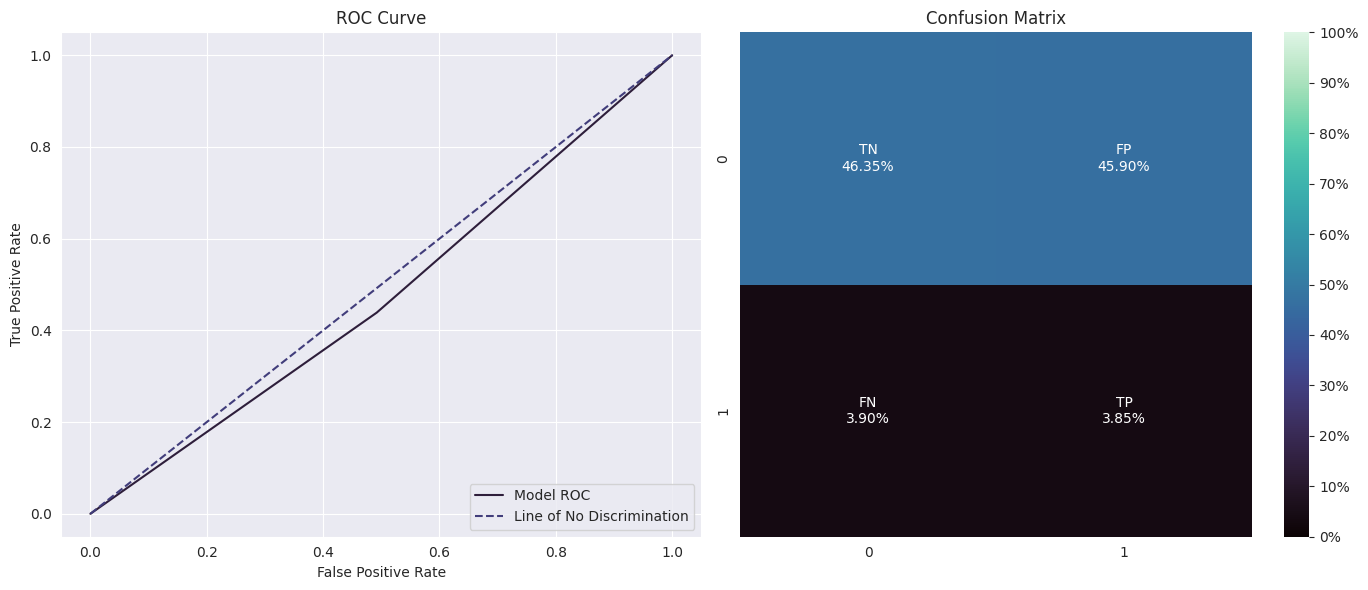

In [67]:
# Train a DummyClassifier with the imputed training data
# Since it's a baseline model, we don't perform hyperparameter tuning and set n_iter to 1
train_model(
    X_train=X_imputed_train,
    y_train=y_imputed_train,
    X_test=X_imputed_test,
    y_test=y_imputed_test,
    estimator=DummyClassifier(
        strategy="stratified"
    ),  # Using the 'stratified' strategy post-SMOTE for balanced prediction
    params={},  # No parameters to tune for DummyClassifier
    cv_metric="business cost",  # Name of CV scoring metric
    scorer=business_cost_scorer,  # Custom scoring function based on business cost
    n_iter=1,  # Single iteration since no tuning
    run_name="Dummy Classifier Business Cost CV",  # Name of the run for MLflow logging
    model_type="DummyClassifier",  # Model type for logging purposes
    smote=True,  # SMOTE to be used in pipeline
    imputed=True,  # Imputed data is used
)

### Logistic Regression Model Training

In this section, we iterate through each scorer, leveraging it for Randomized Search Cross-Validation to optimize the hyperparameters of a Logistic Regression model. Logistic regression is a statistical model that uses a logistic function to model a binary dependent variable based on one or more predictor variables, separating the classes using a hyperplane.

Two major strategies are employed to handle the class imbalance:
- **Oversampling using SMOTE**: Synthetic Minority Over-sampling Technique is utilized to balance the dataset by generating synthetic samples.
- **Class Weighting**: Based on the distribution of the classes in the training data, class weights are computed and adjusted. This approach modulates the emphasis on the minority class during training, optimizing the model's sensitivity to it.

In each iteration the following steps are performed:
- **Display the Current Scorer**: The name of the scorer in use is displayed for clarity in the output.
- **Invoke `train_model`**: 
  - **Hyperparameter Optimization**: Randomized Search CV is used due to computational constraints.
    - **Hyperparameter Space**:
        - **C**: Specifies the inverse of regularization strength. Values range from 0.0001 to 1000, representing both strong and weak regularization.
        - **penalty**: Refers to the norm used in the penalization. Options are L1 (lasso), L2 (ridge), or none.
        - **solver**: The optimization algorithm used by the LR model.
        - **class_weight** (when SMOTE is not used): A range of weight values emphasizing the positive class.
  - **Model Training**: Once optimal hyperparameters are determined, the model is trained.
  - **Logging and Archiving**: Model's parameters, its performance metrics, and the model itself are saved and archived in MLflow.
  - **Visual Feedback**: Performance graphs are generated, displayed and archived, offering immediate insights into the model's efficacy with the current scoring metric.

**Note**: To maintain a clean output, potential compatibility and convergence warnings are temporarily suppressed.


CV metric: ROC-AUC
SMOTE used: True


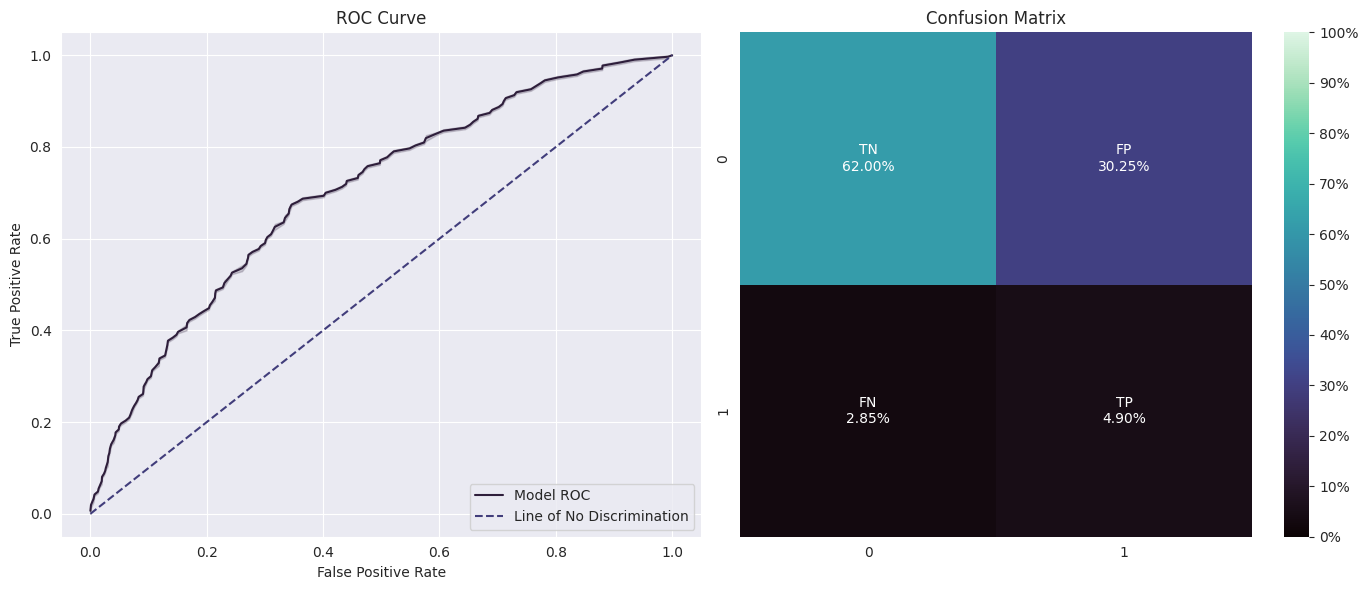

CV metric: Fβ
SMOTE used: True


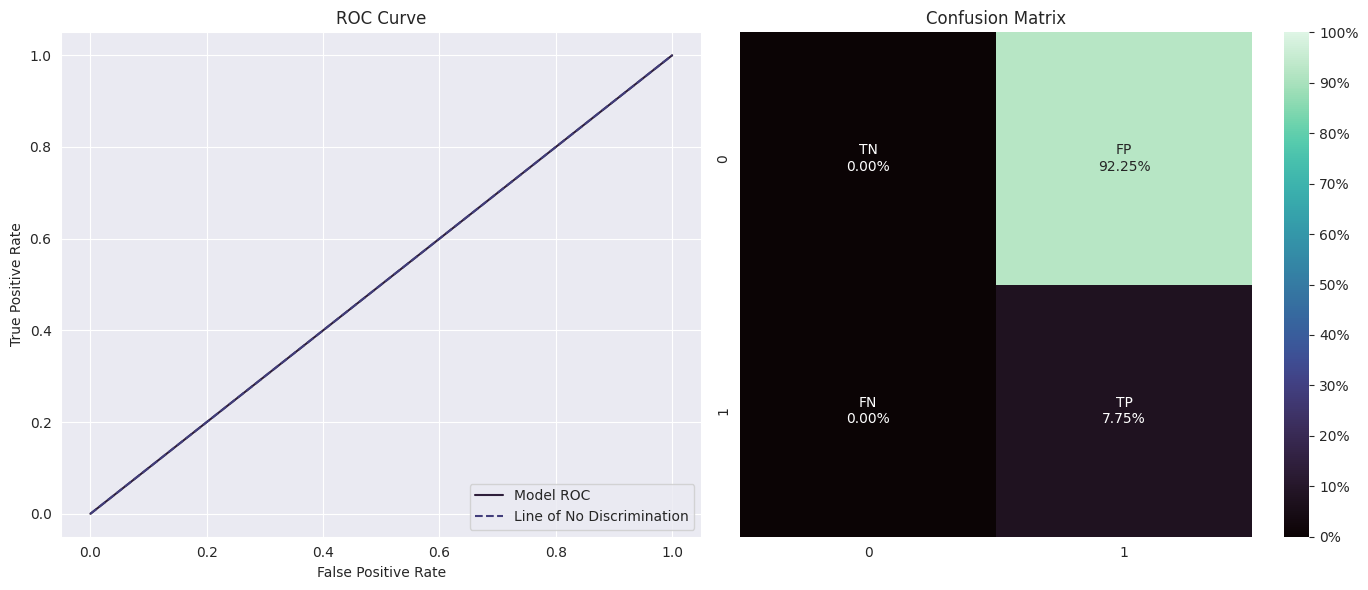

CV metric: business cost
SMOTE used: True


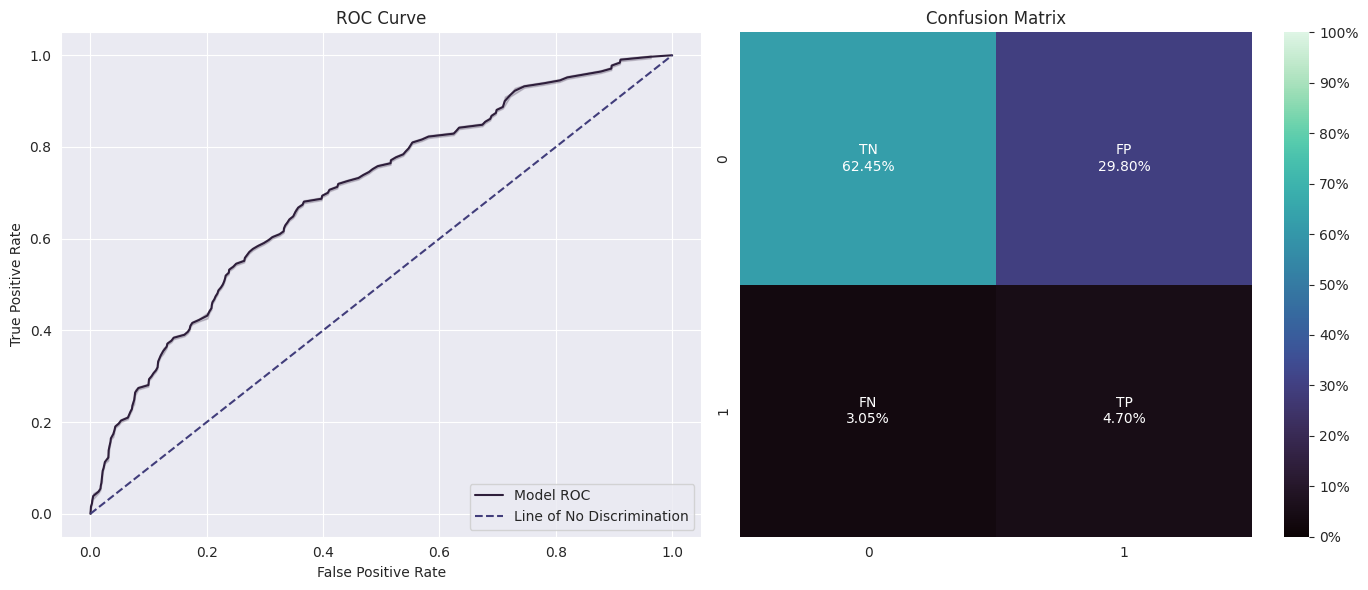

CV metric: ROC-AUC
SMOTE used: False


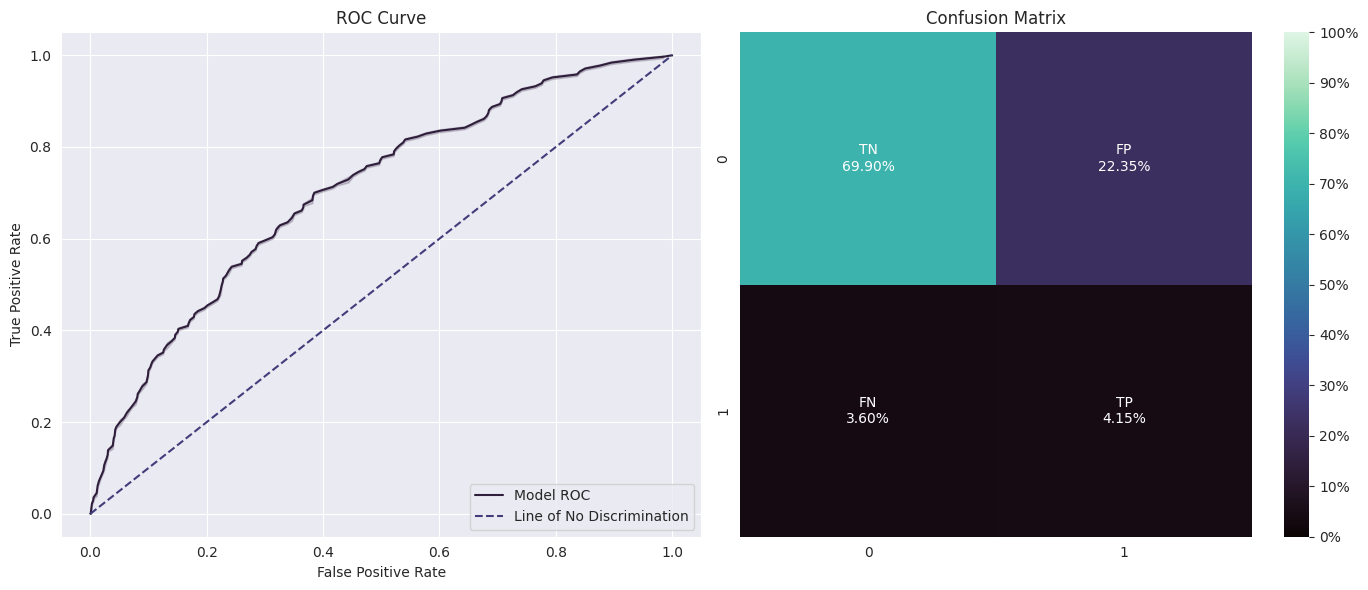

CV metric: Fβ
SMOTE used: False


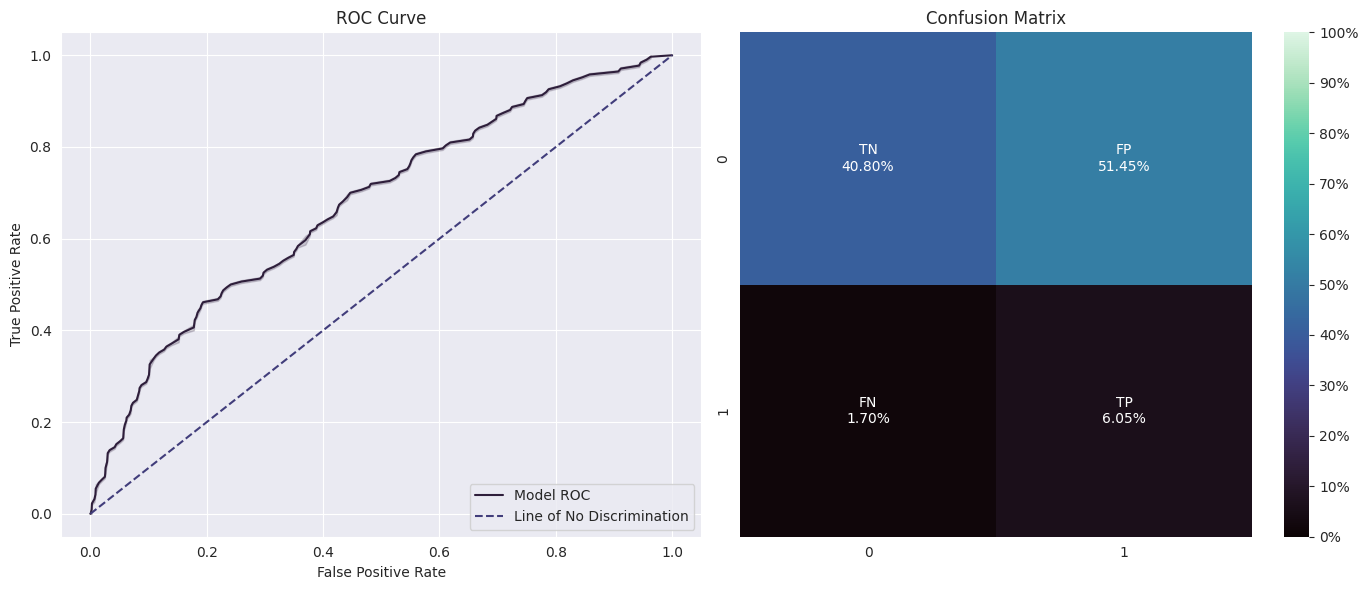

CV metric: business cost
SMOTE used: False


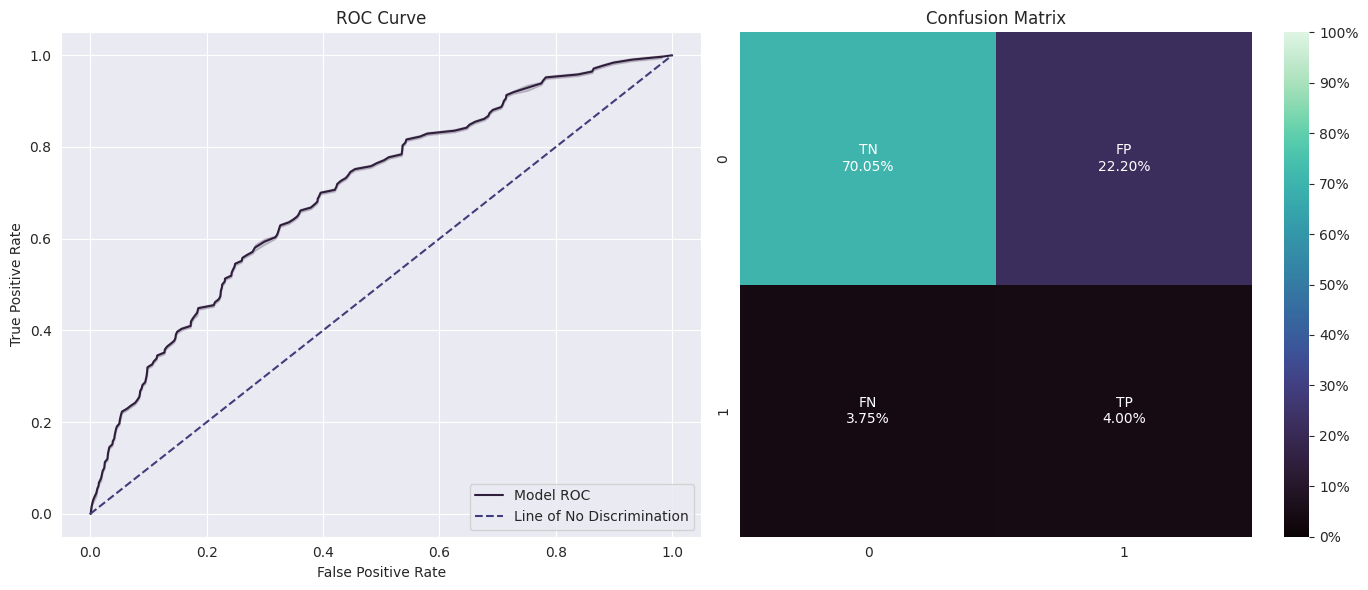

In [68]:
# Suppress potential warnings for clarity during execution
warnings.filterwarnings("ignore")

# Calculate class weights to be used when oversampling is not
class_weights = compute_class_weight("balanced", classes=[0, 1], y=y_train)
base_weights = {0: class_weights[0], 1: class_weights[1]}
# Define a range of positive class weights for hyperparameter tuning
range_pos_weights = [
    {0: base_weights[0], 1: base_weights[1] * factor} for factor in [0.8, 1, 1.2]
]

# Run once with oversampling and once with class weights
for smote in [True, False]:
    # Iterate through each scorer for hyperparameter tuning
    for cv_metric, scorer in scorers:
        # To identify scorer iteration before the performance graphs are displayed
        print(f"CV metric: {cv_metric}")
        # Indicate whether smote and imputed data were used
        print(f"SMOTE used: {smote}")
        # Training the model using Logistic Regression and optimizing its hyperparameters
        train_model(
            X_train=X_imputed_train,
            y_train=y_imputed_train,
            X_test=X_imputed_test,
            y_test=y_imputed_test,
            estimator=LogisticRegression(),  # Using Logistic Regression as the estimator
            # Defining the hyperparameter grid:
            # - C: inverse of regularization strength, where smaller values indicate stronger regularization
            # - penalty: type of regularization (L1, L2, or none)
            # - solver: optimization algorithm
            params={
                "classification__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                "classification__penalty": ["l1", "l2", "none"],
                "classification__solver": ["newton-cg", "lbfgs", "saga"],
            }
            # If SMOTE is not used, apply a range of class weights
            | (
                {"classification__class_weight": range_pos_weights} if not smote else {}
            ),
            cv_metric=cv_metric,  # Name of CV scoring metric
            scorer=scorer,  # Scorer corresponding to CV metric
            n_iter=50,  # Number of iterations for the RandomizedSearchCV
            run_name=f"Logistic Regression: {cv_metric} tuning",  # Name of this MLflow run for tracking
            model_type="LogisticRegression",  # Type of model being trained, for logging in MLflow
            smote=smote,  # Whether SMOTE is used in pipeline
            imputed=True,  # Imputed data is used
        )

# Reset warnings behavior to default
warnings.filterwarnings("default")

### LightGBM Classifier Model Training

This works the same as the previous section, but using a LightGBM model. LightGBM is a gradient boosting framework that employs tree-based learning algorithms. Gradient boosting is an ensemble learning method that builds a series of weak learners (the trees), in a sequential manner, where each tree corrects the errors of its predecessor.

SMOTE cannot handle missing data, so imputed data is used for the first runs, then the original data and imputed datasets are used without oversampling.

In scenarios without SMOTE, the scale_pos_weight is adjusted to counteract class imbalance. This parameter modulates the positive class's weight based on the negative to positive sample ratio.

- **Breakdown of the Hyperparameter Space**:
    - `learning_rate`: This controls the impact of each tree on prediction. Common values are used to balance speed and accuracy.
    - `n_estimators`: The number of boosting iterations (trees): A wide range is used, from 10 to 200.
    - `boosting_type`: The boosting algorithm type: The two most common ones are used - gradient boosting and dropouts.
    - `objective`: Binary classification is defined as the objective of prediction.
    - `num_leaves`: The maximum tree leaves for base learners: Moderate values were chosen.
    - `max_depth`: The maximum tree depth for base learners: relatively shallow (short) trees were chosen.
    - `min_child_samples`: The minimum number of data points per leaf: Values were chosen for sufficient granularity to avoid overfitting.
    - `feature_fraction`: The fraction of features per tree: Values were chosen to balance feature diversity and for overfitting prevention.
    - `bagging_fraction`: The fraction of data used for bagging: Chosen to reduce overfitting while utilizing most of the dataset.
    - `bagging_freq`: The frequency of bagging: A wide range of options is provided, from no bagging to bagging at every iteration.
    - `reg_alpha`: L1 regularization helps in feature selection and prevents overfitting: Values range from none to modest regularization.
    - `reg_lambda`: L2 regularization adds smoothness and stability to the model: Values range from none to modest regularization.
    - `subsample`: Not needed as `bagging_fraction` is used (this prevents warnings).
    - `colsample_bytree`: Not needed as `feature_fraction` is used (this prevents warnings).
    - `subsample_freq`: Not needed as `bagging_freq` is used (this prevents warnings).
    - `scale_pos_weight`: Tunes class weights for better model sensitivity. Though derived from the training sample ratio, providing a range can optimize decision boundaries, particularly when data points are tightly clustered.

CV metric: ROC-AUC
SMOTE used: True
Imputed data used: True


/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/shap/explainers/_permutation.py:208: DeprecationWarning:

shap_values() is deprecated; use __call__().



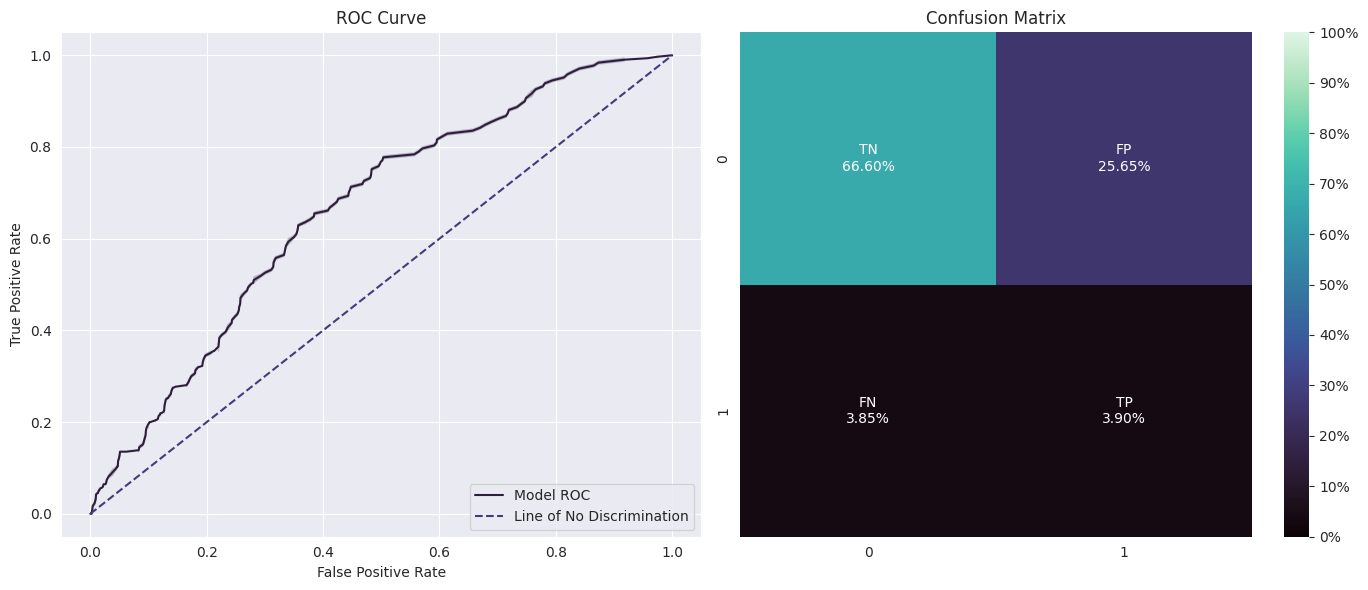

CV metric: Fβ
SMOTE used: True
Imputed data used: True


/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/shap/explainers/_permutation.py:208: DeprecationWarning:

shap_values() is deprecated; use __call__().



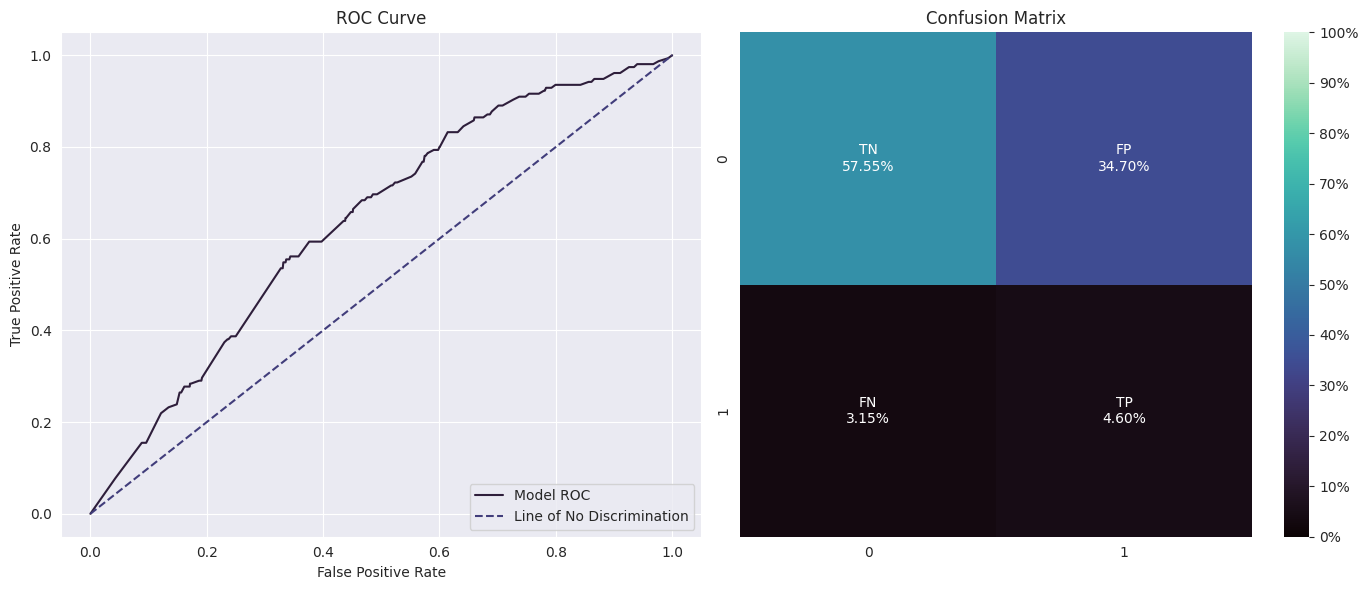

CV metric: business cost
SMOTE used: True
Imputed data used: True


/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/shap/explainers/_permutation.py:208: DeprecationWarning:

shap_values() is deprecated; use __call__().



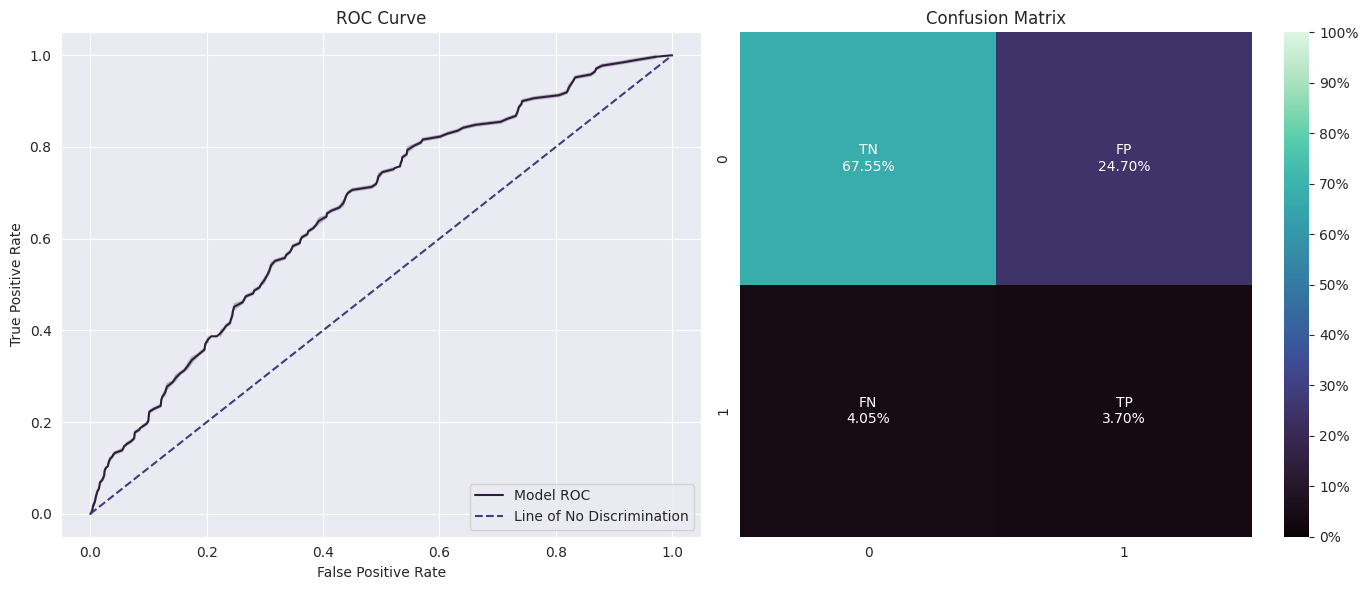

CV metric: ROC-AUC
SMOTE used: False
Imputed data used: True


/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/shap/explainers/_permutation.py:208: DeprecationWarning:

shap_values() is deprecated; use __call__().



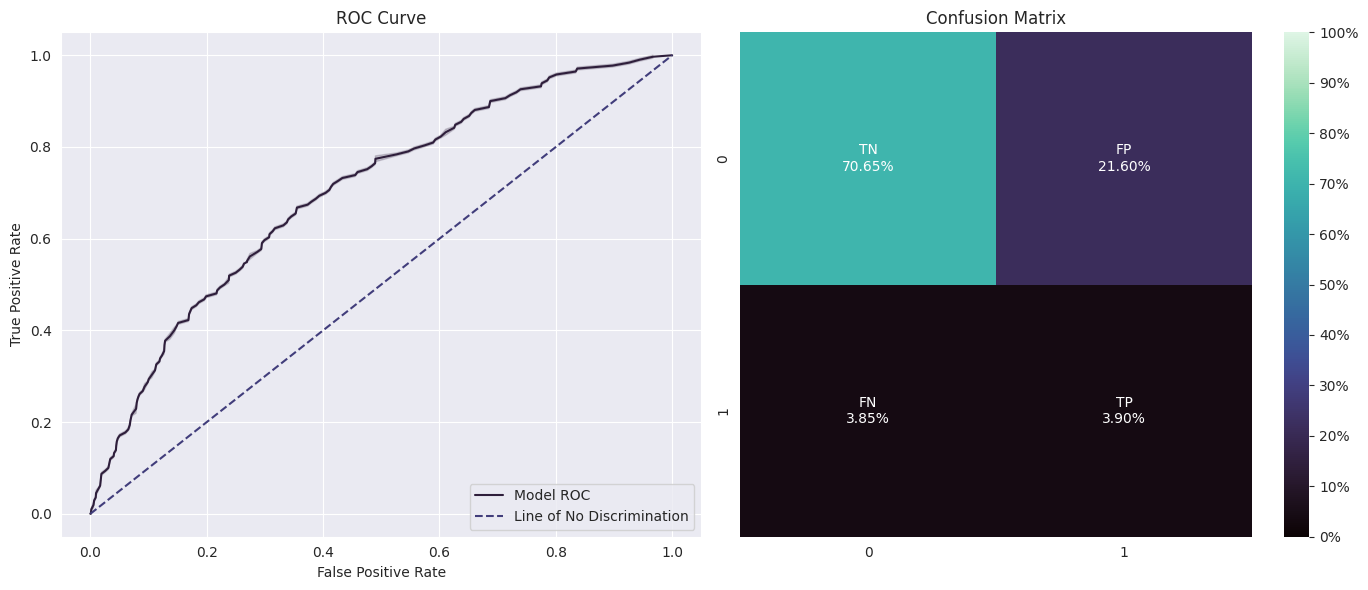

CV metric: Fβ
SMOTE used: False
Imputed data used: True


/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/shap/explainers/_permutation.py:208: DeprecationWarning:

shap_values() is deprecated; use __call__().



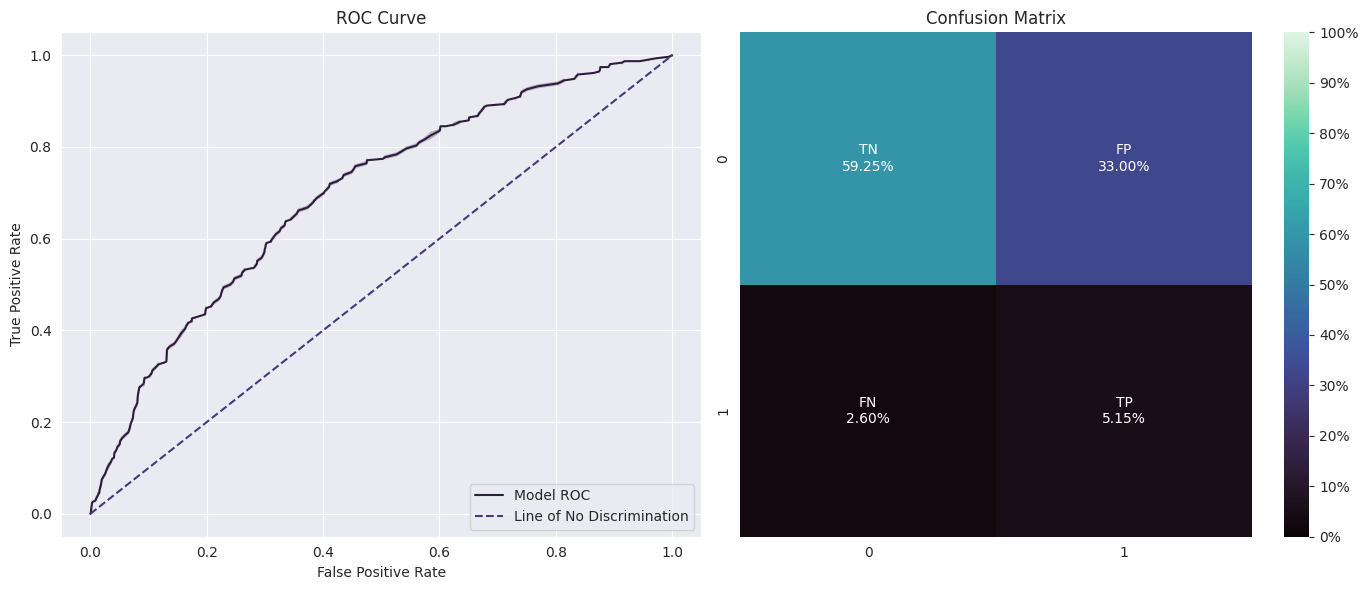

CV metric: business cost
SMOTE used: False
Imputed data used: True


/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/shap/explainers/_permutation.py:208: DeprecationWarning:

shap_values() is deprecated; use __call__().



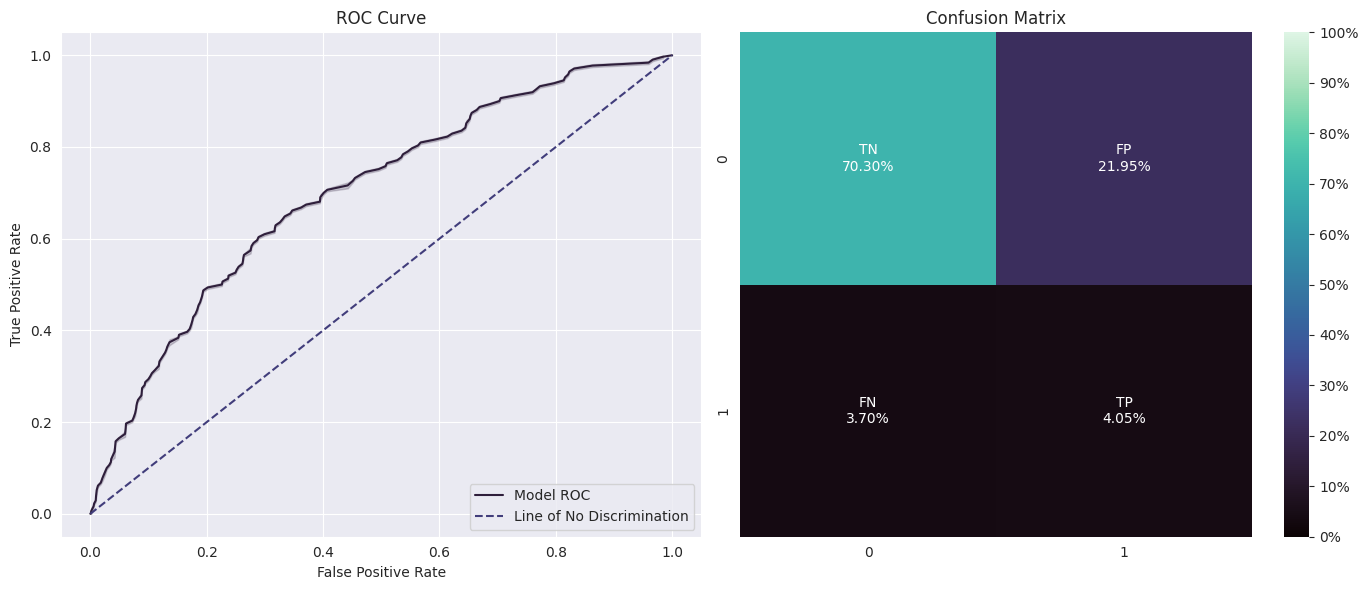

CV metric: ROC-AUC
SMOTE used: False
Imputed data used: False


/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/shap/explainers/_permutation.py:208: DeprecationWarning:

shap_values() is deprecated; use __call__().



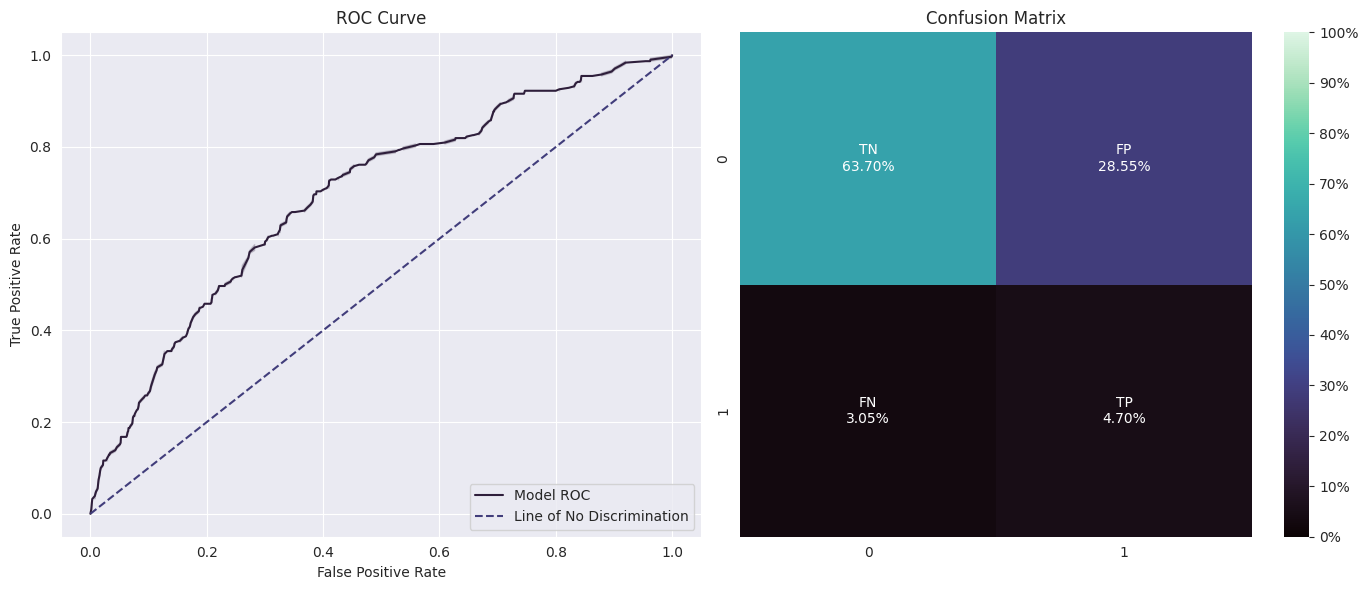

CV metric: Fβ
SMOTE used: False
Imputed data used: False


/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/shap/explainers/_permutation.py:208: DeprecationWarning:

shap_values() is deprecated; use __call__().



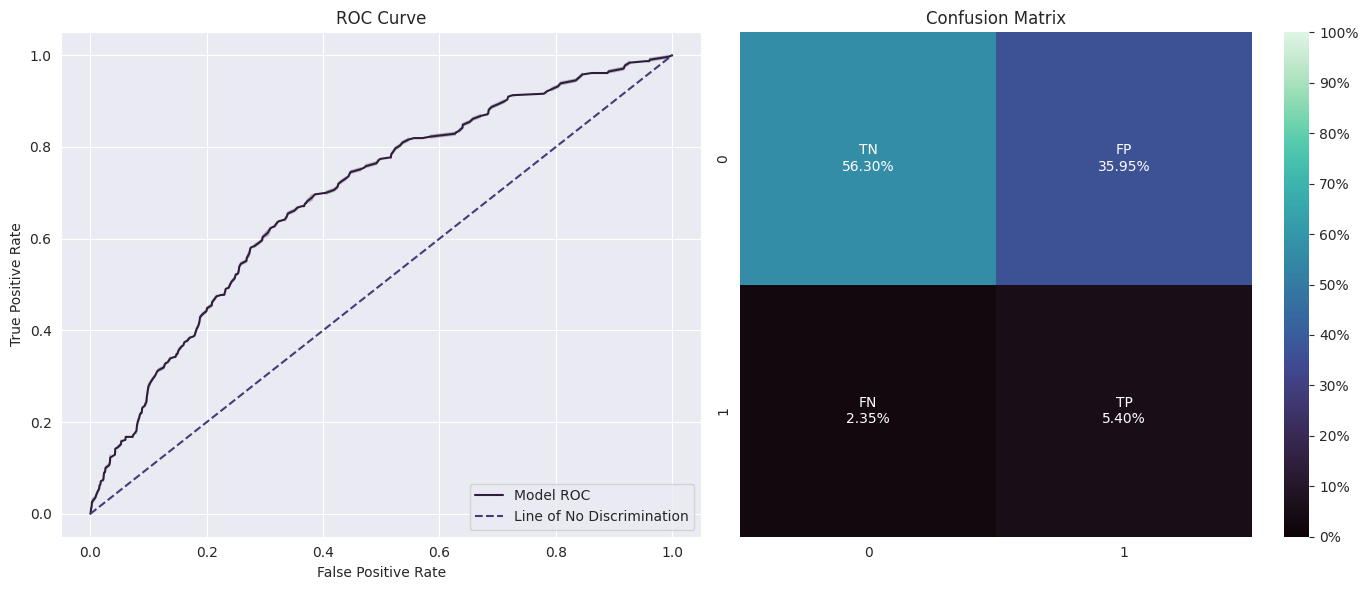

CV metric: business cost
SMOTE used: False
Imputed data used: False


/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/shap/explainers/_permutation.py:208: DeprecationWarning:

shap_values() is deprecated; use __call__().



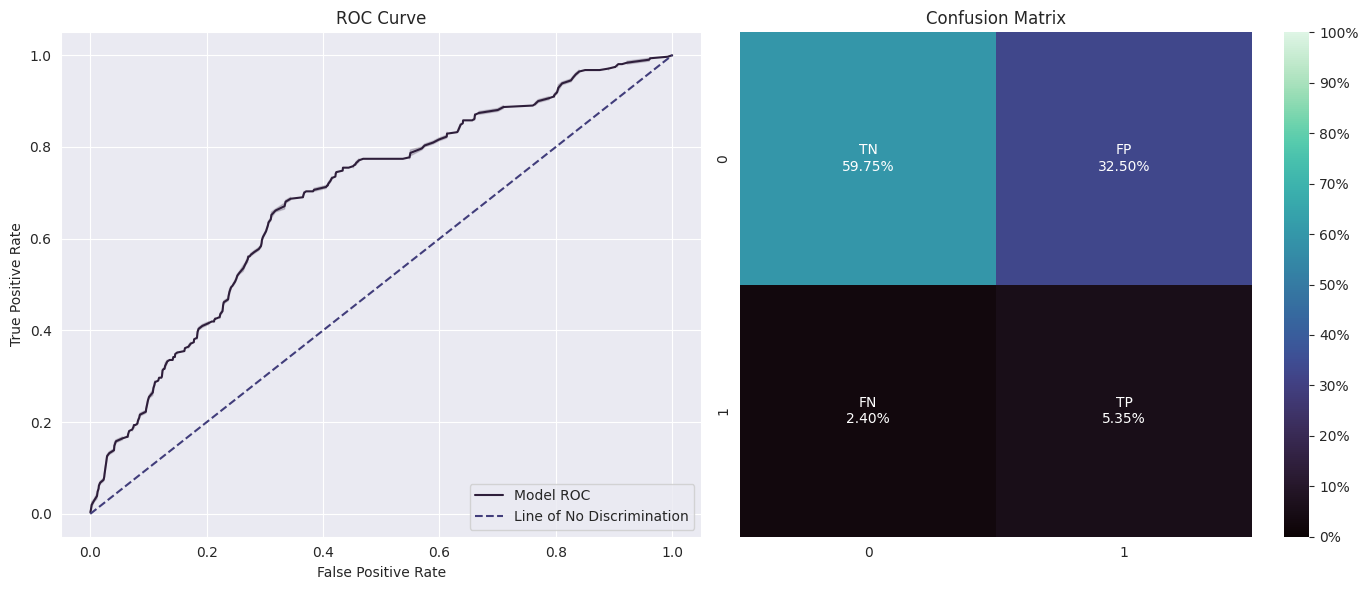

In [69]:
# Different strategies for oversampling and imputation are defined
smote_imputed = [[True, True], [False, True], [False, False]]
# Calculate positive class weight for scenarios without SMOTE
scale_pos_weight_value = sum(y_train == 0) / sum(y_train == 1)

# The strategies are iterated through
for smote, imputed in smote_imputed:
    # Iterate through each scorer for hyperparameter tuning
    for cv_metric, scorer in scorers:
        # To identify scorer iteration before the performance graphs are displayed
        print(f"CV metric: {cv_metric}")
        # Indicate whether smote and imputed data were used
        print(f"SMOTE used: {smote}")
        print(f"Imputed data used: {imputed}")
        # Initiate hyperparameter tuning and training for the LGBMClassifier
        train_model(
            X_train=X_imputed_train if imputed else X_train,
            y_train=y_imputed_train if imputed else y_train,
            X_test=X_imputed_test if imputed else X_test,
            y_test=y_imputed_test if imputed else y_test,
            estimator=lgb.LGBMClassifier(),
            params={
                # Controls the impact of each tree on prediction; common values to balance speed and accuracy
                "classification__learning_rate": [0.01, 0.05, 0.1],
                # Number of boosting iterations
                "classification__n_estimators": [10, 20, 50, 100, 200],
                # Algorithm type: two most common, gradient boosting and dropouts
                "classification__boosting_type": ["gbdt", "dart"],
                # Binary classification
                "classification__objective": ["binary"],
                # Maximum tree leaves for base learners; moderate values corresponding to potential depth
                "classification__num_leaves": [15, 30, 60],
                # Maximum tree depth for base learners; relatively short trees
                "classification__max_depth": [2, 3, 4],
                # Minimum number of data points per leaf; chosen for sufficient granularity to avoid overfitting
                "classification__min_child_samples": [20, 25, 30],
                # Fraction of features per tree; balances feature diversity and overfitting prevention.
                "classification__feature_fraction": [0.6, 0.8, 1.0],
                # Fraction of data for bagging; reduces overfitting while utilizing most of the dataset.
                "classification__bagging_fraction": [0.8, 0.9, 1.0],
                # Frequency of bagging; provides options from no bagging to every iteration.
                "classification__bagging_freq": [0, 1, 2],
                # L1 regularization helps in feature selection and prevents overfitting; none to modest regularization.
                "classification__reg_alpha": [0, 1, 2],
                # L2 regularization adds smoothness and stability to the model; none to modest regularization.
                "classification__reg_lambda": [0, 1, 10],
                # Not needed as bagging_fraction is used (prevents warnings)
                "classification__subsample": [None],
                # Not needed as feature_fraction is used (prevents warnings)
                "classification__colsample_bytree": [None],
                # Not needed as bagging_freq is used (prevents warnings)
                "classification__subsample_freq": [None],
            }
            # Add a range of positive class weights if oversampling is not used
            | (
                {
                    "classification__scale_pos_weight": [
                        scale_pos_weight_value * 0.8,
                        scale_pos_weight_value,
                        scale_pos_weight_value * 1.2,
                    ]
                }
                if not smote
                else {}
            ),
            cv_metric=cv_metric,  # Name of CV scoring metric
            scorer=scorer,  # Scorer corresponding to CV metric
            n_iter=50,
            run_name=f"LightGBM: {cv_metric} tuning",  # Name of this MLflow run for tracking
            model_type="LGBMClassifier",
            smote=smote,  # Whether SMOTE is used in the pipeline
            imputed=imputed,  # Whether imputed data is used
        )

### Data Drift Analysis

In this section, the aim is to understand if there's any data drift between the training and test datasets for the independent features. Data drift can occur when the statistical properties of the input features, which the model uses for predictions, change over time. This can lead to model performance degradation if not addressed.

- The "Evidently" package is used to perform the analysis because of its ability to provide a comprehensive and visually intuitive report on feature drift, offering both statistical tests and visual plots to capture potential shifts in feature distributions.
- Drift detection configuration:
    - Numerical features statistical test: We use the Wasserstein Distance (also known as the Earth Mover's Distance) which measures the distance between two probability distributions. It essentially calculates the minimum cost required to transform one distribution into the other, providing a measure of dissimilarity. This method is sensitive to changes in location, scale, and shape of distributions, making it a robust choice for drift detection.
    - Categorical features: Note that all columns are treated as numerical due to preprocessing steps that have encoded or transformed original categorical variables.
- The report is generated and saved as `data_drift_report.html`.

In [70]:
# Prepare the datasets
drift_train_df = pd.read_feather("input/train_df.ftr")[final_ind_feats]
drift_test_df = pd.read_feather("input/test_df.ftr")[final_ind_feats]

# Create and run the Data Drift Report
data_drift_report = Report(metrics=[DataDriftPreset(num_stattest="wasserstein")])
data_drift_report.run(reference_data=drift_train_df, current_data=drift_test_df)

# Save report as HTML
data_drift_report.save_html("data_drift_report.html")

/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/evidently/utils/dashboard.py:190: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/evidently/nbextension/static/index.js' mode='r' encoding='utf-8'>

/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/evidently/utils/dashboard.py:194: ResourceWarning:

unclosed file <_io.BufferedReader name='/home/gabriel/OC_DS_Projects/project_7/venv/lib/python3.10/site-packages/evidently/nbextension/static/material-ui-icons.woff2'>



### Saving Data for use by the API

In this section, we're preparing and saving the data that our API will use:

1. **Model Selection:**
    - We use MLflow to fetch runs from the experiment with the ID "0".
    - These runs are sorted by the metric `bus_cost_test` to determine the best model (higher values of `bus_cost_test` are better).
    - From the best run, we fetch the URI to access the associated artifacts (like the model and the training data).

2. **Data Loading:**
    - The best model is loaded from the artifact URI and is ready for predictions.
    - The training data `X_train`, saved as a pickle file, is also loaded. It will be used by the `shap.Explainer` for model interpretation, specifically for computing SHAP values to understand the impact of different features on the predictions.

3. **Demo Applicants Data:**
    - For demonstration purposes, we're creating a smaller set (`demo_applicants`) by sampling 100 instances from our processed test data.
    - This data will be used by our API for demonstration and testing purposes.

4. **Saving:**
    - All this data (the model, `X_train`, and `demo_applicants`) is saved in a directory named `api_data` at the root of our project.
    - The model is saved as a pickle file for quick loading, while the dataframes are saved as CSV files for easy inspection and use.

This structured approach ensures that our API has all the necessary components readily available and in the expected format.


In [71]:
# Retrieve runs for the experiment with ID "0", sort them by 'bus_cost_test' in descending order,
# and take the best run (i.e., the first row after sorting)
best_run = (
    mlflow.search_runs(experiment_ids=["0"])
    .sort_values(by="metrics.bus_cost_test", ascending=False)
    .iloc[0]
)

# Get the URI (Uniform Resource Identifier) for the artifacts associated with the best run
artifact_uri = best_run.artifact_uri

# Construct the path to the saved model by joining the artifact URI with the model type (either "LogisticRegression" or "LGBMClassifier")
model_path = os.path.join(artifact_uri, best_run["params.model_type"])

# Construct the path to the saved 'X_train' DataFrame (stored as a pickle file) using the artifact URI
x_train_path = os.path.join(artifact_uri, "X_train.pkl")

# Construct the path to the saved global feature importance JSON using the artifact URI
glob_feat_import_path = os.path.join(artifact_uri, "glob_feat_import.json")

# Load the trained model from its path
model = mlflow.sklearn.load_model(model_uri=model_path)

# Load the 'X_train' DataFrame from its pickle file
X_train = pd.read_pickle(x_train_path)

# Take samples of approved and denied applicants to visualize feature distribution
approved_sample = X_imputed_train[y_imputed_train == 1]
denied_sample = X_imputed_train[y_imputed_train == 0].sample(n=approved_sample.shape[0])

# Create a demo applicants DataFrame by:
# - Concatenating 'SK_ID_CURR_test' series and 'X_imputed_test' DataFrame side-by-side (column-wise)
# - Renaming the series to "SK_ID_CURR"
# - Sampling 100 rows randomly
# - Resetting the index of the resulting DataFrame
demo_applicants = (
    pd.concat(
        [SK_ID_CURR_test.reset_index(drop=True), X_imputed_test.reset_index(drop=True)],
        axis=1,
    )
    .rename(columns={SK_ID_CURR_test.name: "SK_ID_CURR"})
    .sample(n=100)
    .reset_index(drop=True)
)

# Define the path where the API data (model and CSV files) will be saved
api_data_path = "./api/data"

# If the specified directory doesn't exist, create it
if not os.path.exists(api_data_path):
    os.makedirs(api_data_path)

# Save the trained model as a pickle file in the 'api_data' directory
with open(os.path.join(api_data_path, "model.pkl"), "wb") as f:
    pickle.dump(model, f)

# Save the 'X_train' DataFrame as a CSV file in the 'api_data' directory
X_train.to_csv(os.path.join(api_data_path, "X_train.csv"), index=False)

# Save the 'approved_sample' and 'denied_sample' DataFrames as CSV files in the 'api_data' directory
approved_sample.to_csv(os.path.join(api_data_path, "approved_sample.csv"), index=False)
denied_sample.to_csv(os.path.join(api_data_path, "denied_sample.csv"), index=False)

# Save the 'demo_applicants' DataFrame as a CSV file in the 'api_data' directory
demo_applicants.to_csv(os.path.join(api_data_path, "demo_applicants.csv"), index=False)

# Copy the 'glob_feat_import' JSON (stripping the 'file://' prefix from the path) to the 'api_data' directory
shutil.copy(
    glob_feat_import_path.replace("file://", "", 1),
    os.path.join(api_data_path, "glob_feat_import.json"),
)

'./api/data/glob_feat_import.json'